In [18]:
#Setup
library(SummarizedExperiment)
library(MultiAssayExperiment)
library(glmnet)
library(Matrix)
library(parallel)
library(droplasso)
library(ROCR)
#subsample 
subsample <- function(xtrain,m) 
{dev=lapply(1:ncol(xtrain), function(x) sd(xtrain[,x]))
sortedev=sort(unlist(dev))
xtrainb=xtrain[,which(dev > sortedev[length(sortedev)-m])]
return(xtrainb)}

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:S4Vectors’:

    space

The following object is masked from ‘package:stats’:

    lowess




## Introduction


Given training dataset x with labeles y, droplasso solves the following optimization problem 
\begin{equation}
 \underset{w \in \mathbb{R}^d}{min}  \left ( R_{dropLasso} (x,y,w)  \right ) = \underset{w \in \mathbb{R}^d}{min}   \underset{\delta_1,...,\delta_n \sim B(p)}{ \mathbb {E}} ?\left( \frac{1}{n} \sum_{i=1}^{n}L(y_{i}, w^{\top} (\mathbf{\delta_{i}}  \odot x_{i,}))   +  \lambda .  \left \| w\right \|_{1} \right) 
\end{equation}

We want to compare the performance of the DropLasso with ElasticNet using the Conquer database [conquer](http://imlspenticton.uzh.ch:3838/conquer/) 



## Data processing
Data is downloaded from the conquer database website [conquer](http://imlspenticton.uzh.ch:3838/conquer/). For each dataset we:
1. Select the count_lstpm normalized gene expression. 
2. Select a binary label from the set of pghenotypes in the annotations in the dataset. 
3. Subsample the dataset according to the label (usually balanced, if not take the min)
4. Remove genes that are not expressed for those samples (0 norm)
5. We create 5-folds with a 1/5 th of the data for training, 1/5 th for validation (selection of the best parameters), and the remaining 3/5th for testing the accuracy (AUC). 


In [12]:
data <- readRDS(gzcon(url("http://imlspenticton.uzh.ch/robinson_lab/conquer/data-mae/EMTAB2805.rds")))

(data_gene <- experiments(data)[["gene"]])
data_count= t(assays(data_gene)[["count"]])
data_lstpm= t(assays(data_gene)[["count_lstpm"]])

pdata <- colData(data)

pos=which(pdata$cell_cycle_stage=="G1")
neg=which(pdata$cell_cycle_stage=="S")
y= c(rep(0,length(pos)),rep(1,length(neg)))
 
norm_data=sapply(1:ncol(data_lstpm),function(i) norm(as.matrix(data_lstpm[,i])))
data_lstpm=data_lstpm[,-which(norm_data==0)]


xtrain_lstpm= data_lstpm[c(pos,neg),] 
xtrain_count=data_count[c(pos,neg),]


#We use count_lstpm and normalize

n=nrow(xtrain_lstpm)
nrepeats <- 2
nfolds <- 5
folds <- list()
for (i in seq(nrepeats)) {
    folds <- c(folds,split(sample(seq(n)), rep(1:nfolds, length = n)))
}

for (i in 1:10)
{ itrain=folds[[i]]
norm_data=sapply(1:ncol(xtrain_lstpm[itrain,]),function(i) norm(as.matrix(xtrain_lstpm[itrain,i])))
xtrain_lstpm=xtrain_lstpm[,-which(norm_data==0)]
}
                 
xtrain=scale(xtrain_lstpm,center=F)
            

class: RangedSummarizedExperiment 
dim: 45686 288 
metadata(0):
assays(4): TPM count count_lstpm avetxlength
rownames(45686): ENSMUSG00000000001.4 ENSMUSG00000000003.15 ...
  ERCC-00170 ERCC-00171
rowData names(3): gene genome symbol
colnames(288): G1_cell1 G1_cell10 ... S_cell95 S_cell96
colData names(0):


The datasets selected are : 
- EMTAB2805
- GSE45719
- GSE63818
- GSE48968

## Cross validation procedure and example

The cross validation is done in parallel on a cluster for each fold and each parameter. Code can be seen in this markdown (here we use directly the Cfunction in the package droplasso for matter of convenience with this particular cluster).
Elastic net and DropLasso both have two parameters.We vary the Elasticnet $\lambda_{el}$ parameter over a large grid of $100$ values, and  $\alpha_{el}$ over 10 regularly spaced values between $0$ and $1$, estimate the classification performance on the test set in terms of area under the receiving operator curve (AUC), and report the best average AUC over the grid of the two parameters. We do the same for DropLasso after transformation of the values of the two parameters using the equations system in the paper, in order to have a fair comparaison in the same parameters space. 
Here is an example of the wrapper function used to evaluate the accuracy for one fold, and a set of parameters.

In [24]:
seqalpha=rev(c(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1))
seqlambda=c(as.vector(sapply(-20:78,function(j) 10^(-0.1*j) )),0)

accuracy <- function(iexp,ind1,ind2)
{   xtrain=scale(xtrain,center=F)
    n=nrow(xtrain)
    d=ncol(xtrain)
itrain <- folds[[iexp]]
ival= folds[[(iexp%%10+1)]]


# penalized elasticnet

m_glm=glmnet(xtrain[itrain,],y[itrain],family="binomial",lambda=seqlambda[ind1],alpha=seqalpha[ind2],intercept = F,standardize = F)
ypred <- (xtrain[ival,]) %*% m_glm$beta
pred <- prediction(ypred[,1],y[ival])
auc_el_val_val <- performance(pred, "auc")@y.values[[1]]
a_el_val=length(which(m_glm$beta[,1]==0))


ypred <- (xtrain[-c(ival,itrain),]) %*% m_glm$beta
pred <- prediction(ypred[,1],y[-c(itrain,ival)])
auc_el_test <- performance(pred, "auc")@y.values[[1]]
a_el=length(which(m_glm$beta[,1]==0))

n_passes=1
m <- droplasso(xtrain[itrain,], y[itrain], family="binomial", keep_prob=1/(1+seqlambda[ind1]*(1-seqalpha[ind2])/2), lambda= seqlambda[ind1]*seqalpha[ind2], n_passes = n_passes,decay=0.1)

ypred <- (xtrain[ival,]) %*% m$beta
pred <- prediction(ypred[,1],y[ival])
auc_dl_val_val <- performance(pred, "auc")@y.values[[1]]
a_dl_val=length(which(m$beta==0))

ypred <- (xtrain[-c(ival,itrain),]) %*% m$beta
pred <- prediction(ypred[,1],y[-c(itrain,ival)])
auc_dl_test <- performance(pred, "auc")@y.values[[1]]
a_dl=length(which(m$beta==0))

  
acc=c(auc_el_val_val,auc_el_test,auc_dl_val_val,auc_dl_test,a_el_val,a_el,a_dl_val,a_dl,seqlambda[ind1],seqalpha[ind2],iexp)
return(acc)
}


#preprocessing results                              
acc_dl_val = matrix(0,nrow=0,ncol=6)
acc_el_val= matrix(0,nrow=0,ncol=6)
acc_dl_test = matrix(0,nrow=0,ncol=6)
acc_el_test= matrix(0,nrow=0,ncol=6)

for (lambda in 1:length(seqlambda)){
        for (iexp in 1:length(folds)) {
            for (alpha in 1:length(seqalpha)){
                acc <- accuracy(iexp,lambda,alpha)
                acc_dl_val= rbind(acc_dl_val,c(acc[c(2,6,9,10,11)],100*lambda+alpha))
                acc_el_val= rbind(acc_el_val,c(acc[c(1,5,9,10,11)],100*lambda+alpha))
                acc_dl_test= rbind(acc_dl_test,c(acc[c(4,8,9,10,11)],100*lambda+alpha))
                acc_el_test= rbind(acc_el_test,c(acc[c(3,7,9,10,11)],100*lambda+alpha))
            }
        }
    }

    

#Average Validation and Test accuracy for all folds:  

auc_el_val=cbind(sortedXyData(acc_el_val[,6], acc_el_val[,1])[,2],sortedXyData(acc_el_val[, 6], acc_el_val[,2])[,2],sortedXyData(acc_el_val[, 6], acc_el_val[,3])[,2],sortedXyData(acc_el_val[, 6], acc_el_val[,4])[,2],sortedXyData(acc_el_val[, 6], acc_el_val[,5])[,2])
auc_dl_val=cbind(sortedXyData(acc_dl_val[,6], acc_dl_val[,1])[,2],sortedXyData(acc_dl_val[, 6], acc_dl_val[,2])[,2],sortedXyData(acc_dl_val[, 6], acc_dl_val[,3])[,2],sortedXyData(acc_dl_val[, 6], acc_dl_val[,4])[,2],sortedXyData(acc_dl_val[, 6], acc_dl_val[,5])[,2])


auc_el_test=cbind(sortedXyData(acc_el_test[,6], acc_el_test[,1])[,2],sortedXyData(acc_el_test[, 6], acc_el_test[,2])[,2],sortedXyData(acc_el_test[, 6], acc_el_test[,3])[,2],sortedXyData(acc_el_test[, 6], acc_el_test[,4])[,2],sortedXyData(acc_el_test[, 6], acc_el_test[,5])[,2])
auc_dl_test=cbind(sortedXyData(acc_dl_test[,6], acc_dl_test[,1])[,2],sortedXyData(acc_dl_test[, 6], acc_dl_test[,2])[,2],sortedXyData(acc_dl_test[, 6], acc_dl_test[,3])[,2],sortedXyData(acc_dl_test[, 6], acc_dl_test[,4])[,2],sortedXyData(acc_dl_test[, 6], acc_dl_test[,5])[,2])


#Select the Test accuracy corresponding to the best validation accuracy parameters:  

auc_el_best=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),]
auc_dl_best=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),]


auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),]
auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(10,1000,10),1])),]


#Computing the p-value between the best Test accuracies of Elasticnet and droplasso: 
acc_el_best=acc_el_test[which((acc_el_test[,3]==auc_el_best[3])&(acc_el_test[,4]==auc_el_best[4])),1]
acc_dl_best=acc_dl_test[which((acc_dl_test[,3]==auc_dl_best[3])&(acc_dl_test[,4]==auc_dl_best[4])),1]

f=var.test(acc_dl_best, acc_el_best)$p.value
p=t.test(acc_dl_best, acc_el_best,var.equal=(f>0.05),paired=F)$p.value

#Saving the validation and test accuracy as a Rdata file per dataset 
#save(auc_el_val,auc_dl_val,auc_el_test,auc_dl_test,p,file="auc_EMTAB2805_lstpm_all_S_G1_val_p.Rdata")




## Results 
The above experiment is run in our case in a computing cluster due to long computational time.
The results are reported as Rdata files [here] (https://github.com/BeyremKh/Droplasso-experiments/tree/master/single_cell/results) 

Here we plot the test AUC of droplasso and ElasticNet as a function of the number of variables selected by the model (results are produced by the above code ran in the cluster).

Here is the plot with the test AUC for the original datasets for the corresponding methods: 

Warning message in all_auc_el[4] = auc_el_test[which(auc_el_val[, 1] == max(auc_el_val[, :
“le nombre d'objets à remplacer n'est pas multiple de la taille du remplacement”

     datanames                                                  
[1,] "data"           "Lasso" "dropout" "ElasticNet" "DropLasso"
[2,] "EMTAB2805_S_G1" "0.719" "0.763"   "0.843"      "0.86"     
[3,] "EMTAB2805"      "0.907" "0.915"   "0.905"      "0.923"    
[4,] "GSE45719_16_8"  "0.736" "0.658"   "0.813"      "0.828"    
[5,] "GSE63818_7_10"  "0.774" "0.724"   "0.942"      "0.95"     
[6,] "GSE48968"       "0.96"  "0.948"   "0.97"       "0.971"    
[7,] "GSE48968_4_6"   "0.569" "0.54"    "0.599"      "0.61"     


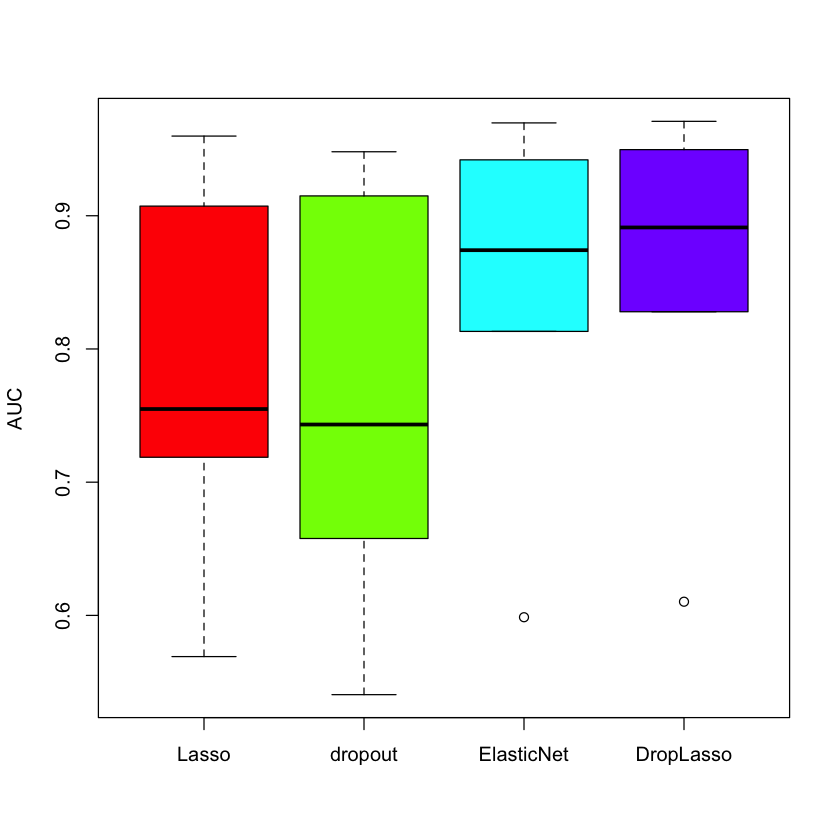

In [1]:
all_auc_el=rep(0,6)
all_auc_dl=rep(0,6)
all_auc_l=rep(0,6)
all_auc_dr=rep(0,6)
datanames= c("EMTAB2805_S_G1","EMTAB2805","GSE45719_16_8","GSE63818_7_10","GSE48968","GSE48968_4_6")
load("results/auc_EMTAB2805_lstpm_all_S_G1_val_p.Rdata")
all_auc_el[1]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),1]
all_auc_dl[1]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),1]
all_auc_l[1]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),1]
all_auc_dr[1]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(1,1000,10),1])),1]

load("results/auc_EMTAB2805_lstpm_all_val_p.Rdata")
all_auc_el[2]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),1]
all_auc_dl[2]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),1]
all_auc_l[2]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),1]
all_auc_dr[2]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(1,1000,10),1])),1]

load("results/auc_GSE45719_lstpm_all_16_8_val_p.Rdata")
all_auc_el[3]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),1]
all_auc_dl[3]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),1]
all_auc_l[3]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),1]
all_auc_dr[3]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(1,1000,10),1])),1]

load("results/auc_GSE63818_lstpm_all_7_10_val_p.Rdata")
all_auc_el[4]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),1]
all_auc_dl[4]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),1]
all_auc_l[4]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),1]
all_auc_dr[4]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(1,1000,10),1])),1]

load("results/auc_GSE48968_lstpm_all_val_p.Rdata")
all_auc_el[5]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),1]
all_auc_dl[5]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),1]
all_auc_l[5]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),1]
all_auc_dr[5]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(1,1000,10),1])),1]

load("results/auc_GSE48968_lstpm_all_4_6_val_p.Rdata")
all_auc_el[6]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[,1])),1]
all_auc_dl[6]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[,1])),1]
all_auc_l[6]=auc_el_test[which(auc_el_val[,1]==max(auc_el_val[seq(1,1000,10),1])),1]
all_auc_dr[6]=auc_dl_test[which(auc_dl_val[,1]==max(auc_dl_val[seq(1,1000,10),1])),1]

print(rbind(c("data","Lasso","dropout","ElasticNet","DropLasso"),cbind(datanames,round(all_auc_l,digits=3),round(all_auc_dr,digits=3),round(all_auc_el,digits = 3),round(all_auc_dl,digits=3))))

boxplot(cbind(all_auc_l,all_auc_dr,all_auc_el,all_auc_dl),col=rainbow(4),xaxt='n',ylab='AUC')
axis(side=1,1:4,c("Lasso","dropout", "ElasticNet","DropLasso"))